In [194]:
# IMPORTS

from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from skl2onnx import to_onnx
from torch import nn
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
import torch.nn.functional as F
import torch, onnx, io, dill
import numpy as np
import onnxruntime as ort
import lightning as pl
import copy
import matplotlib.pyplot as plt

In [195]:
# CONFIGURATION

INPUT_SHAPE = (128, 128)
NUM_CHANNELS = 3
TEST_SIZE = 0.15
SEED = 42
SESSION_NAME = '4_CAE_SVM'
MODEL_NAME = 'cae_svm'
LR = 1e-3

In [196]:
# DATA PREPARATION

transform = transforms.Compose([
    transforms.Resize(INPUT_SHAPE),
    transforms.ToTensor(),
])

dataset = ImageFolder('data/raw', transform=transform)

In [197]:
# DATA SPLIT

ds_idx = list(range(len(dataset)))
train_idx, test_idx = train_test_split(ds_idx, test_size=TEST_SIZE, shuffle=True, stratify=dataset.targets, random_state=SEED)

train_ds = Subset(dataset, train_idx)
test_ds = Subset(dataset, test_idx)

In [198]:
# DATALOADER

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

In [199]:
# PREPARE MODEL

class Autoencoder(pl.LightningModule):
    def __init__(self, lr=1e-3):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, 1, 1), nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, 3, 1, 1), nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, 3, 1, 1), nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, 1, 1), nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, 3, 1, 1), nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose2d(256, 128, 3, padding=1),
            nn.ReLU(),

            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose2d(128, 64, 3, padding=1),
            nn.ReLU(),

            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose2d(64, 32, 3, padding=1),
            nn.ReLU(),

            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose2d(32, 16, 3, padding=1),
            nn.ReLU(),
            
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose2d(16, 3, 3, padding=1),
            nn.Sigmoid()
        )
        
        self.lr = lr

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def training_step(self, batch, batch_idx):
        x, _ = batch
        x_hat = self(x)
        loss = F.mse_loss(x_hat, x)
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, _ = batch
        x_hat = self(x)
        val_loss = F.mse_loss(x_hat, x)
        self.log('val_loss', val_loss, prog_bar=True, on_step=False, on_epoch=True)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)
        return optimizer
    
flatten = nn.Flatten()
flatten.eval()

torch.manual_seed(SEED)
cae = Autoencoder(lr=1e-4)

svc = SVC(probability=True)

In [200]:
# TRAIN AUTOENCODER

cb = [
    ModelCheckpoint(save_top_k=3, monitor="val_loss", mode="min", verbose=False),
    EarlyStopping(monitor="val_loss", mode="min", patience=5, verbose=False),
]

trainer = pl.Trainer(max_epochs=-1, callbacks=cb)
trainer.fit(cae, train_loader, test_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 392 K 
1 | decoder | Sequential | 392 K 
---------------------------------------
784 K     Trainable params
0         Non-trainable params
784 K     Total params
3.140     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/Caskroom/miniconda/base/envs/vision/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/Caskroom/miniconda/base/envs/vision/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/Caskroom/miniconda/base/envs/vision/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (42) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [201]:
# GET FEATURES

cae.eval()
X_train = torch.stack([dataset[i][0] for i in train_idx])
X_test = torch.stack([dataset[i][0] for i in test_idx])

X_train_features = flatten(cae.encoder(X_train)).detach()
X_test_features = flatten(cae.encoder(X_test)).detach()

y_train = [dataset[i][1] for i in train_idx]
y_test = [dataset[i][1] for i in test_idx]

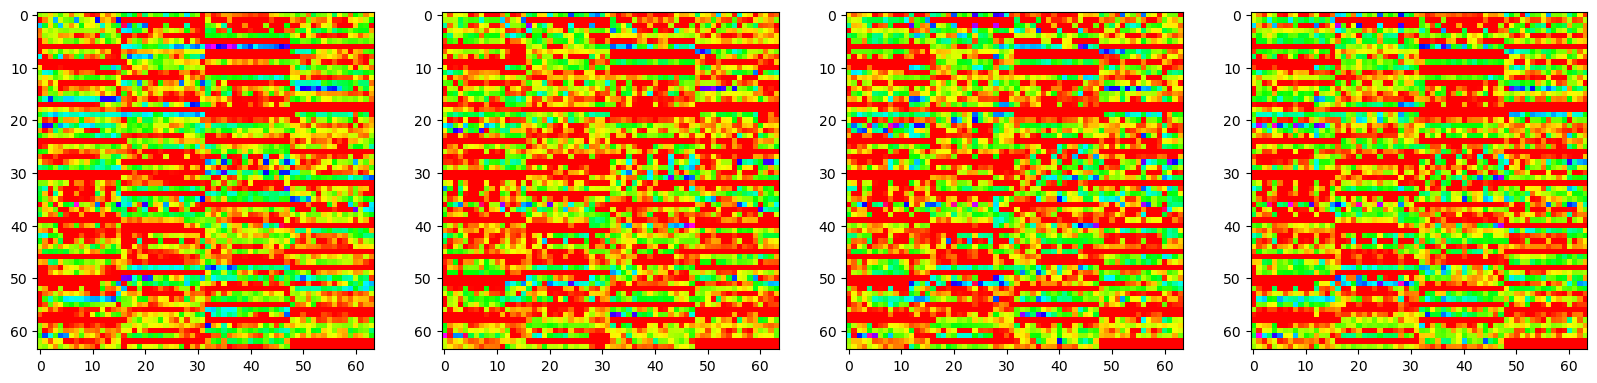

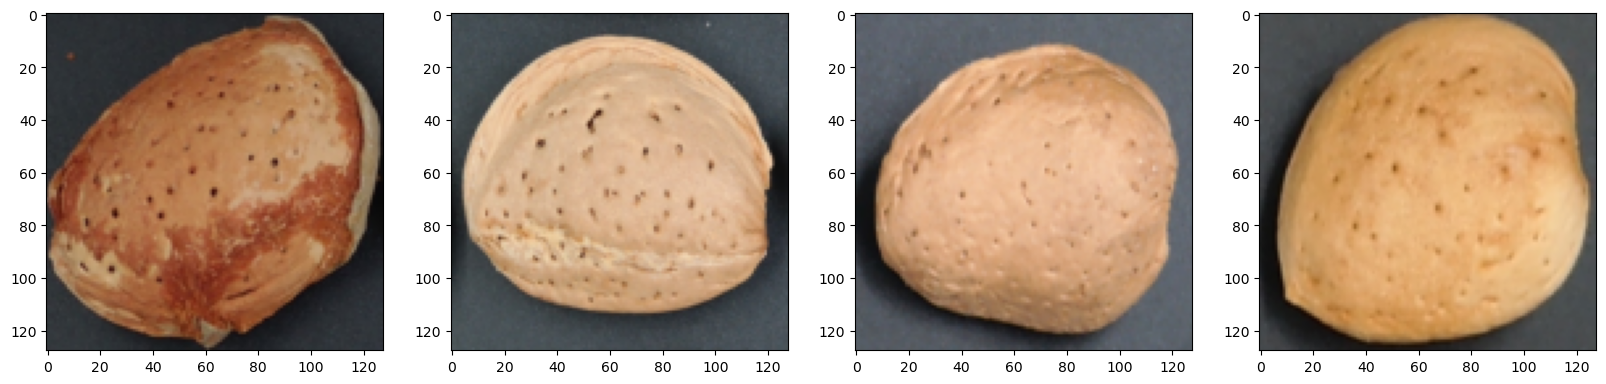

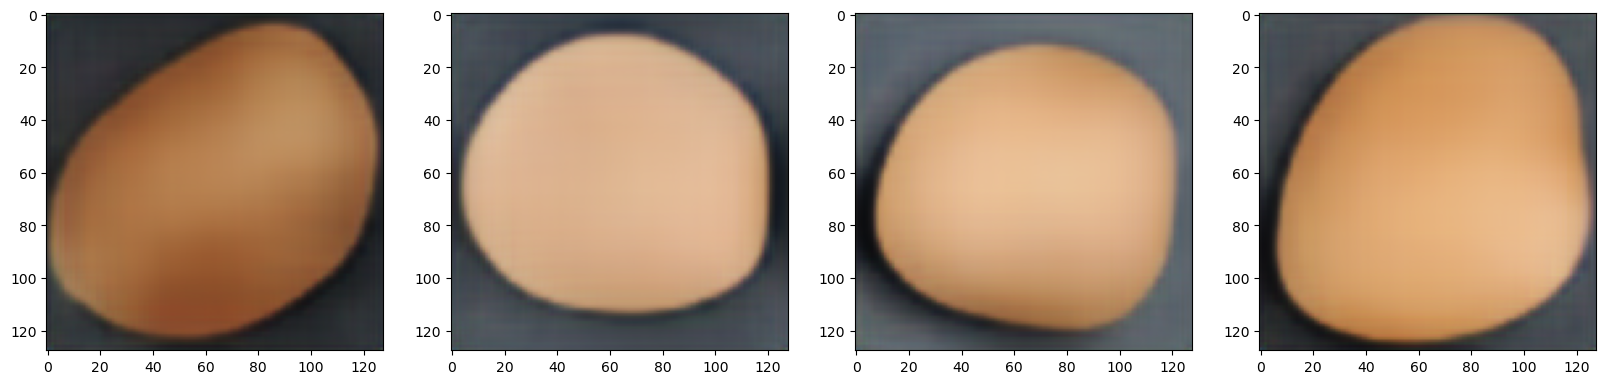

In [205]:
# VISUALIZE FEATURES, ORIGINAL, RECONSTRUCTED

plt.figure(figsize=(20, 5))
for i, class_name in enumerate(dataset.classes):
    plt.subplot(1, 4, i+1)
    plt.imshow(X_test_features[y_test.index(i)].reshape(64, 64, 1), cmap='hsv')
    
plt.figure(figsize=(20, 5))
for i, class_name in enumerate(dataset.classes):
    plt.subplot(1, 4, i+1)
    plt.imshow(X_test[y_test.index(i)].permute(1, 2, 0))
    
plt.figure(figsize=(20, 5))
for i, class_name in enumerate(dataset.classes):
    image = X_test[y_test.index(i)].unsqueeze(0)
    image = cae(image).detach()
    plt.subplot(1, 4, i+1)
    plt.imshow(image.permute(0, 2, 3, 1).squeeze(0))

In [203]:
# HYPERPARAMETER TUNING (RSCV)

param_dist = {
    'C': np.logspace(-3, 3, 7),
    'gamma': np.logspace(-3, 3, 7)
}

rscv = RandomizedSearchCV(svc, param_dist, cv=10, n_jobs=-1, random_state=SEED, scoring='accuracy', verbose=3)

In [206]:
# TRAINING CLASSIFIER (SVC)

rscv.fit(X_train_features, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV 2/10] END .............C=0.01, gamma=1000.0;, score=0.293 total time= 1.1min
[CV 3/10] END .............C=0.01, gamma=1000.0;, score=0.295 total time= 1.2min
[CV 1/10] END .............C=0.01, gamma=1000.0;, score=0.301 total time= 1.1min
[CV 6/10] END .............C=0.01, gamma=1000.0;, score=0.295 total time= 1.2min
[CV 5/10] END .............C=0.01, gamma=1000.0;, score=0.295 total time= 1.2min
[CV 7/10] END .............C=0.01, gamma=1000.0;, score=0.303 total time= 1.2min
[CV 8/10] END .............C=0.01, gamma=1000.0;, score=0.303 total time= 1.2min
[CV 4/10] END .............C=0.01, gamma=1000.0;, score=0.295 total time= 1.2min
[CV 9/10] END .............C=0.01, gamma=1000.0;, score=0.303 total time= 1.1min
[CV 10/10] END ............C=0.01, gamma=1000.0;, score=0.303 total time= 1.1min
[CV 2/10] END ..............C=1000.0, gamma=1.0;, score=0.316 total time= 1.1min
[CV 1/10] END ..............C=1000.0, gamma=1.

RandomizedSearchCV(cv=10, estimator=SVC(probability=True), n_jobs=-1,
                   param_distributions={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                                        'gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
                   random_state=42, scoring='accuracy', verbose=3)

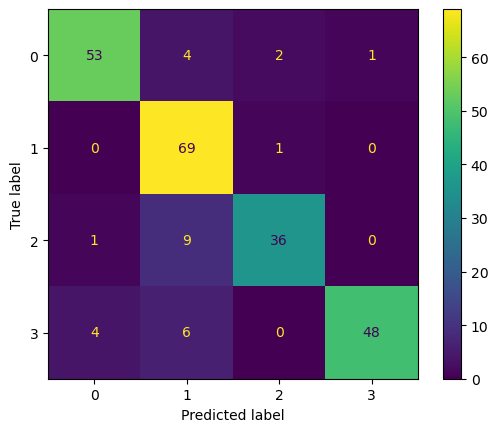

In [207]:
# CONFUSION MATRIX

ConfusionMatrixDisplay.from_estimator(rscv.best_estimator_, X_test_features, y_test)

In [208]:
# CLASSIFICATION REPORT

y_pred = rscv.best_estimator_.predict(X_test_features)
report = classification_report(y_test, y_pred, target_names=dataset.classes)
print(report)

              precision    recall  f1-score   support

          AK       0.91      0.88      0.90        60
   KAPADOKYA       0.78      0.99      0.87        70
       NURLU       0.92      0.78      0.85        46
        SIRA       0.98      0.83      0.90        58

    accuracy                           0.88       234
   macro avg       0.90      0.87      0.88       234
weighted avg       0.89      0.88      0.88       234



In [214]:
# CONVERT TO ONNX

encoder = copy.deepcopy(cae.encoder)
encoder.append(nn.Flatten())

features = io.BytesIO()
torch.onnx.export(
    encoder, 
    torch.rand(1, 3, INPUT_SHAPE[0], INPUT_SHAPE[1]), 
    features, input_names=['input'], output_names=['cae_output'],
    dynamic_axes={'input': {0: '?'}}
)
features = onnx.load_model_from_string(features.getvalue())

classifier = to_onnx(rscv.best_estimator_, np.array(X_test_features[:1]).astype(np.float32), options={"zipmap": False})

graph = onnx.compose.merge_graphs(features.graph, classifier.graph, io_map=[('cae_output', 'X')])
model = onnx.helper.make_model(graph)

# ENCODER
torch.onnx.export(cae.encoder, torch.rand(1, 3, INPUT_SHAPE[0], INPUT_SHAPE[1]), 'models/encoder.onnx', input_names=['input'], output_names=['output'], dynamic_axes={'input': {0: '?'}})

# DECODER
torch.onnx.export(cae.decoder, cae.encoder(torch.rand(1, 3, INPUT_SHAPE[0], INPUT_SHAPE[1])), 'models/decoder.onnx', input_names=['input'], output_names=['output'], dynamic_axes={'output': {0: '?'}})

# CONVOLUTIONAL AUTOENCODER
torch.onnx.export(cae, torch.rand(1, 3, INPUT_SHAPE[0], INPUT_SHAPE[1]), 'models/cae.onnx', input_names=['input'], output_names=['output'], dynamic_axes={'input': {0: '?'}})

In [210]:
# SAVE MODEL

with open(f'models/{MODEL_NAME}.onnx', 'wb') as f:
    f.write(model.SerializeToString())

In [211]:
# SANITY CHECK

sess = ort.InferenceSession(f'models/{MODEL_NAME}.onnx')
output = sess.run(['label', 'probabilities'], {'input': X_test.numpy()})

if (output[0] == y_pred).all():
    print('SUCCESS')
else:
    print('FAILURE')

SUCCESS
